# Quantum Chemistry: Modelling Basics

The aim of this notebook is to provide the basic quantum chemistry knowledge to help solve a chemistry problem with quantum computers. Many parameters can be tweaked, and some have higher impact on the accuracy and the quantum resources (number of qubits, quantum circuit depth and number of measurements) than others. This set of parameters includes the choice of initial state, choice of basis set, and the freezing of molecular orbitals. Some references are provided when needed.

The cell below installs Tangelo and PySCF in the current Python environment.

In [1]:
try:
    import tangelo
except ImportError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git --quiet
    !pip install pyscf --quiet

## Table of Contents

* [Introduction](#1)
* [Computation of the Mean-Field](#2)
    * [Molecular Information](#21)
    * [Restricted vs Unrestricted  Hartree-Fock (RHF/ROHF vs UHF)](#22)
    * [Choice of the Basis Set](#23)
* [Consideration of Correlation Energy - Potential of Quantum Computing](#3)
* [Resource Reduction](#4)
    * [Active Space Selection](#41)
    * [Considering Symmetries](#42)
* [Advanced Usage of PySCF](#5)
    * [Extracting Mean-Field Quantities](#51)
    * [Outputting Cube Files](#52)
* [Closing Words](#6)
* [References](#7)

## Introduction<a class="anchor" id="1"></a>

At the submicroscopic level, experiments have shown that matter behaves according to the principles of quantum mechanics. Quantum effects, modelled via the Schrödinger equation, are essential for studying molecules *in silico*. Quantum chemistry aims at solving the time-independent version of this equation, shown below, for many-electron molecules.

$$
\hat{H} \Psi = E \Psi
$$

Where $\hat{H}$, $\Psi$ and $E$ are respectively the Hamiltonian of the system, the wavefunction and the eigenvalue associated with $\hat{H}$. 

As stated in the postulates of quantum mechanics, the wavefunction $\Psi$ encodes all the information of the system. One who knows the electronic wavefunction of a molecular system can therefore predict measurement outcomes of an experiment. This is a highly valuable asset for academia and industrial purposes, to help develop new drugs or functional materials.

The analysis of natural products is an efficient way of quickly getting inspiration for the design of new materials, while taking into account the million years of evolution that nature had to optimize a biochemical process. For instance, one difficult thing to do in the laboratory is to change the spin state of a compound during a chemical reaction. Nature circumvents this problem by leveraging transition metals to achieve this challenging task: the oxygen fixation process is achieved by the heme biomolecule, where a Fe(II) atom is involved in the spin state change mechanism (see figure below) [[10.1074/jbc.M314007200](https://doi.org/10.1074/jbc.M314007200)].

![FeIIPorImO2 system](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/img/FeIIPorImO2.png?raw=1)

Fully understanding the mechanism of oxygen fixation, that is to say knowing the rate constants for all elementary reactions, would lead to valuable insights for the design of chemical catalysts. Achieving this goal would take us one step closer to [*making the world cleaner, healthier, and more sustainable*](https://goodchemistry.com/). This is one of the main applications of quantum chemistry. 

However, the Schrödinger equation shown above cannot be solved exactly for systems beyond one electron, i.e. all relevant chemical systems for industrial applications. There are two equivalent ways of expressing the time-independant Schrödinger equation, whether the phase-space variables are trajectories (first quantization) or fields (second quantization).

In the first quantization form, the electronic Hamiltonian $\hat{H}$ for $N$ electrons is

$$
\hat{H} = -\frac{\hbar^2}{2 m_e} \sum_i \nabla_i^2 -\frac{e^2}{4 \pi \epsilon_0} \sum_i \sum_A \frac{Z_A}{r_{iA}} + \frac{e^2}{4 \pi \epsilon_0} \sum_i \sum_{j>i} \frac{1}{r_{ij}}
$$

Where $m_e$, $\nabla^2$, $e$, $Z_A$, $r_{iA}$ and $r_{ij}$ are respectively the electron mass, the Laplacian, the elementary charge, the relative charge of nucleus $A$, the distance between the nucleus $A$ and the electron $i$ and the distance between electron $i$ and $j$. 

In the second quantization form, the electronic Hamiltonian is expressed as

$$
H = \sum_{pq}h_{pq} a_p^{\dagger}a_q + \frac{1}{2}\sum_{pqrs}h_{pqrs}a_p^{\dagger}a_r^{\dagger}a_s a_q
$$

Where $h_{pq}$ and $h_{pqrs}$ refer respectively to the one-body and two-body integrals. 

For more information about the state-of-the-art theories and methods in quantum chemistry, the reader is invited to read the references at the end of this notebook. The scope of this notebook is to provide clues on how to choose input parameters for modelling molecules on quantum computers with Tangelo. As quantum resources are still scarce, the definition of the problem is a crucial step in an end-to-end quantum chemistry experiment on quantum hardware. To keep a reasonable runtime for this notebook, we work with a simple example, the dioxygen molecule.

In [2]:
o2_xyz = [("O", (0., 0., 0.)), ("O", (0., 0., 1.21))]

## Computation of the Mean-Field<a class="anchor" id="2"></a>

The computation of the mean-field is usually the first step of all post Hartree-Fock approaches, which we describe in another section below. The mean-field approaches solve the Schrödinger equation by averaging the electron-electron repulsion term in a self-consistent way. In other words, each electron does not explicitely interact with other electrons. Depending on the molecular information, discussed shortly, different flavours of mean-field solutions can be computed.

### Molecular Information<a class="anchor" id="21"></a>

This notebook focuses on the second quantization formalism. In this case, chemical information is encapsulated in a `SecondQuantizedMolecule` object.

When defining a molecule, one must specify molecular properties. One of them is the total charge of the system, i.e. the difference between the number of electrons and the total nuclear charge (default value is 0). This is an important property when dealing with oxydo-reduction reactions where cations (deficit in electrons) and anions (surplus in electrons) are involved. Another important quantity to specify is the spin, defined by the difference between the number of alpha and beta electrons (default value is 0). This allows radical systems to be modelled: a spin of 0 characterizes a restricted-shell molecule while a spin different from 0 defines an open-shell system.

In the next cell, the dioxygen molecule data structure is constructed. The ground state of the dioxygen molecule is neutral and is a triplet state (q=0 and spin=2).

In [3]:
from tangelo import SecondQuantizedMolecule
o2_sto3g = SecondQuantizedMolecule(o2_xyz, q=0, spin=2)
print(f"{o2_sto3g.n_active_mos} active molecular orbitals")
print(f"{o2_sto3g.n_active_electrons} active electrons")

8 active molecular orbitals
12 active electrons


/home/alex/.pyenv/versions/qsdk/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In the above output, there are missing orbitals and electrons. The default implementation of Tangelo freezes the core orbitals; for the O$_2$ molecule, two orbitals, corresponding to the 1p atomic orbitals, are frozen. The next sections elaborate on the impact of the basis sets and frozen orbitals.

### Restricted vs Unrestricted  Hartree-Fock (RHF/ROHF vs UHF)<a class="anchor" id="22"></a>

The mean-field solution is automatically computed when the `SecondQuantizedMolecule` object is created. With the provided spin, it computes the relevant mean-field -- that is to say the Restricted or Restricted Open-Shell Hatree-Fock solution (RHF or ROHF). Using those methods, the spin-orbitals are treated as pairs, so each molecular orbital can accept up to two electrons. The unrestricted Hartree-Fock (UHF) mean-field calculation, where the spin-orbitals are considered individually, usually results in more accurate energies for open-shell systems. Tangelo supports all three approaches. Further  details about the RHF, ROHF and UHF methods can be found in [Szabo & Ostlund](https://books.google.ca/books/about/Modern_Quantum_Chemistry.html?id=6mV9gYzEkgIC&redir_esc=y).

### Choice of the Basis Set<a class="anchor" id="23"></a>

The many-electron Schrödinger equation is typically solved in a basis of molecular orbitals which are expressed as a linear combination of atomic orbitals (LCAO). LCAO coefficients, used to construct molecular orbitals, are obtained through the minimization of the total energy, according to the variational principle. For convenience, the basis is usually represented by atom-centered functions for molecular systems, or plane-wave functions in solid-state physics.

In early quantum chemistry, basis sets were constructed with decreasing exponential functions ($e^{-\alpha r}$). This strategy was referred to as *Slater Type Orbitals* (STOs). With the increase of computational resources, the use of Gaussian functions ($e^{-\alpha r^2}$) was popularized. Using those Gaussian functions is much more efficient than the STO strategy for computing the numerous overlap integrals needed in quantum chemistry. This is the main point of using a *Gaussian Type Orbitals* (GTOs) wavefunction.

State-of-the-art basis sets are constructed from many Gaussian primitives. The Pople notation is one of the most explicit notations for basis sets:
- The hyphen symbol (-) separates the reference to core and valence orbitals;
- The digits represent the number of Gaussian primitives in a function;
- There are as many digits as there are functions for each atomic orbital (zeta $\zeta$);
- The letter G refers to the use of Gaussian functions.

As an example, the `3-21G` double zeta basis set uses three Gaussian primitives for each core orbital and a set of two plus one Gaussian primitives for the valence orbitals. More information, examples and discussions about the GTOs can be found in this [link](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry/11.02%3A_Gaussian_Basis_Sets).

Below are popular basis set examples used in quantum chemistry.

In [4]:
basis_sets = [
    "STO-3G",       # Simple zeta, minimal basis.
    "3-21G",        # Double zeta.
    "6-31G",        # Double zeta with more Gaussian primitives.
    "6-31G(d,p)",   # Polarization functions (+ 5 d-orbitals for all atoms except H, +3 p-orbitals for H atoms) added.
    "6-311G(d,p)",  # Triple zeta with polarization functions.
    "6-311+G(d,p)", # Triple zeta with polarization functions and diffuse functions.
    "cc-pvqz",      # Quadruple zeta.
    "cc-pv5z"       # Quintuple zeta.
]

The wavefunction for a molecule is an approximation when using a finite basis set,

$$
\Phi_{\text{approx}} = \sum_{i=0}^N c_i |i \rangle
$$

According to the variational principle, considering $\Phi_{\text{approx}}$ is normalized, the approximated energy is greater or equals to the true ground-state energy.

$$
\langle \Phi_{\text{approx}} | \hat{H} | \Phi_{\text{approx}} \rangle = \epsilon_{\text{approx}} \geq  \epsilon_{\text{true}}
$$

As the basis set grows larger, the resulting approximation draws closer to the true wavefunction.

$$
\Phi_{\text{approx}} = \sum_{i=0}^{\infty} c_i |i \rangle \approx \Psi_{\text{true}}
$$

However, increasing the basis set size has the effect of increasing the number of parameters to optimize, therefore extending the required computational resources in space (amount of memory) and in time (number of operations). As we shall see shortly, it is often a good idea to balance the basis set size to optimize the time to solution versus the target accuracy ($|\epsilon_{\text{approx}} -  \epsilon_{\text{true}}|$), as the increase in the basis set complexity yields diminishing returns in accuracy gain.

A full list of available basis sets supported in [PySCF](https://pyscf.org/) (therefore also in Tangelo) is available at this [link](https://pyscf.org/_modules/pyscf/gto/basis.html). Also, the [Basis Set Exchange](https://www.basissetexchange.org/) initiative hosts a collection of bases for every atom in the periodic table. With this constantly increasing number of bases available to the community, choosing a basis set can be a challenging task. The theory states that an infinite basis is the way of getting the true wavefunction. In practice, it is not possible to perform calculations using an infinite basis, and compute the true wavefunction. We can however select finite basis sets and tailor our approaches to the use cases.
- As a rule of thumb, a double zeta (e.g. `6-31G` or `cc-pvdz`) is the minimum basis size required to get semi-quantitative energies.
- For molecules with a high electronegativity difference between atoms, adding polarization functions (e.g. `6-31G**` or `6-31G(d,p)`) is recommended.
- Diffuse functions (e.g. `6-31G+(d,p)`) should be included when dealing with anions. Diffuse functions are functions with small coefficients (small $\alpha$ in $e^{-\alpha r^2}$) that can fit the electronic density far from the nucleus.
- Effective Core Potential (ECP) basis sets are needed when dealing with heavier atoms with relativistic and non-trivial effects (for example, the iodine atom is often modelled in the `LANDL2DZ` basis).

In the next cell, we demonstrate the effect of the basis on the total energy calculations and time to solution.

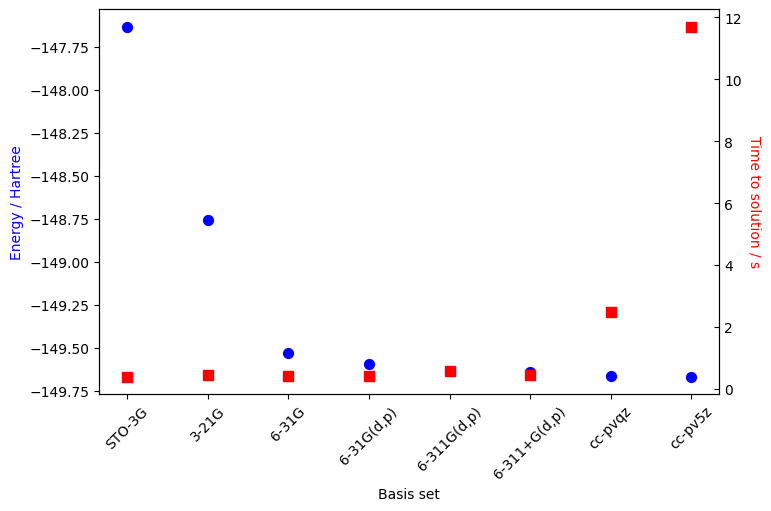

In [5]:
import time
import matplotlib.pyplot as plt

mf_energies = list()
mf_times = list()

# Perform a Mean-Field calculation for each basis set.
for bs in basis_sets:
    
    # Measure execution time.
    start = time.time()
    scan_basis_mol = SecondQuantizedMolecule(o2_xyz, q=0, spin=2, basis=bs)
    end = time.time()
    
    mf_energies.append(scan_basis_mol.mf_energy)
    mf_times.append(end-start)

# Create the matplotlib figure.
fig, ax = plt.subplots(figsize=(8,5))

# Plot the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plot the time to solution.
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Show the graph.
plt.tick_params(axis="both", direction="in")
plt.show()

We see in the previous graph that increasing the basis complexity brings the energy eigenvalue closer to the true Hartree-Fock energy. This trend can be generalized to other methods as well, like [CCSD](https://en.wikipedia.org/wiki/Coupled_cluster), [MP2](https://en.wikipedia.org/wiki/M%C3%B8ller%E2%80%93Plesset_perturbation_theory), [FCI](https://en.wikipedia.org/wiki/Full_configuration_interaction), (...) although the time to solution would be greater for those post Hartree-Fock approaches. The takeaway is that even if an infinite basis is required to converge to the true energy, there are diminishing returns at some point, especially when considering the time required for the calculation. In our case, `6-311G(d,p)` appears as a good choice in term of accuracy and compute time.

## Consideration of Correlation Energy - Potential of Quantum Computing
<a class="anchor" id="3"></a>

Post Hatree-Fock methods are meant to consider the electronic correlation energy. The correlation energy is defined as

$$
E_{\text{corr}} = E - E_{\text{HF}}
$$

In which $E$ and $E_{\text{HF}}$ are the energies computed from exact diagonalization of the molecular Hamiltonian within the Born-Oppenheimer approximation (i.e. Full Configuration Interaction (FCI)) and the Hartree-Fock method, respectively. Since it is computationally prohibitive to solve the FCI problem, with the exception of very small systems, it is typical to introduce approximations to include correlation effects in electronic structure calculations. The FCI problem considers the diagonalization of the Hamiltonian in a basis of all possible excited determinants, that is all possible 1-, 2-, 3-, …, N-body determinants for an N-electron system. Hence, the FCI wavefunction is a linear combination of all possible determinants for an N-electron system.  Approximate methods, only include a subset of the excited determinants in the approximate wavefunction in order to capture the most important correlation effects (e.g. many-body perturbation theory, coupled-cluster theory). 

This correlation energy can be split into two categories: static and dynamical correlation. To consider the former, one should use multi-configuration approaches. The latter can be tackled with post Hartree-Fock methods with a single reference state, like Configuration Interaction (CI), Coupled-Cluster (CC) or perturbative methods (MP2, MP3, ...). Going beyond this explanation is out of scope for this notebook, therefore we encourage the user to read on the subject in [Szabo & Ostlund](https://books.google.ca/books/about/Modern_Quantum_Chemistry.html?id=6mV9gYzEkgIC&redir_esc=y).

We saw in the previous section that the `6-311G(d,p)` is a good compromise to compute the O$_2$ ground state. In this basis, the dioxygen molecule is described by 72 bases (spin orbitals) and 16 electrons. To get the highest fidelity versus the true wavefunction with the current best method (Full Configuration Interaction), one would need ${72 \choose 16} \approx 3 \times 10^{13}$ configurations. Even if we somehow managed to represent each configuration as a single byte of data, 4.11 petabytes would still be needed to store the full wavefunction of the dioxygen molecule. This effect is amplified when dealing with relevant industrial molecules like organometallic complexes or proteins. Going through the classical formalism of quantum chemistry is therefore not a viable solution.

With the occupation transformation (Jordan-Wigner [[Zeitschrift für Physik, 47, p. 631–651 (1928)](https://doi.org/10.1007/BF01331938)]), this problem vanishes. By leveraging the quantum superposition principle in a straightforward way, it is possible to map this O$_2$ triplet ground state to 72 qubits (empty and filled spin orbitals are mapped to the $|0\rangle$ and $|1\rangle$ states, respectively). This fact is behind the emerging enthusiasm of the quantum computing community for chemistry applications. We should note that even if the space limitation is mitigated, no consensus is established for the time complexity, correlated to the number of gates and measurement required to approximate the molecular wavefunction [[arXiv:2009.12472](https://doi.org/10.48550/arXiv.2009.12472)].

## Resource Reduction<a class="anchor" id="4"></a>

Resource reduction refers to lowering the computational requirements to run an algorithm. This applies to both classical and quantum computing. In conventional computing, this translates to less bits required to store information and less operations to do on these bits. For the gate-model quantum computing, this translates to reducing the number of qubits and the number of gates in quantum circuits.

Our starting point is the O$_2$ molecule in the `6-311G(d,p)` basis. We focus on reducing resource requirements before choosing an algorithm to compute the ground state. For approaches relying on choosing a different ansatz or fragmenting a molecule into smaller subproblems (problem decomposition), the user can refer to the relevant notebooks in the [Tangelo-Examples repository](https://github.com/goodchemistryco/Tangelo-Examples).

In [6]:
o2_6311gdp = SecondQuantizedMolecule(o2_xyz, q=0, spin=2, 
                                     basis="6-311G(d,p)", frozen_orbitals=None)
print(f"{o2_6311gdp.n_active_mos} active molecular orbitals")
print(f"{o2_6311gdp.n_active_electrons} active electrons")

36 active molecular orbitals
16 active electrons


The O$_2$ molecule in the 6-311G(d,p) basis would require 72 qubits and inherently a quantum circuit that is considered too deep for current architectures (NISQ devices) at the time of writing. Decreasing the number of qubits required to encode the problem provides the first indirect way to reduce those requirements. The two methods discussed below are the reduction of the active space and the consideration of molecular symmetries.

### Active Space Selection<a class="anchor" id="41"></a>

Active space selection is a trivial way to reduce the number of qubits by ignoring some molecular orbitals in the post-Hartree-Fock calculation. Applying this method is trivial, but choosing which molecular orbitals to freeze is not. While there is no general algorithm to perform that operation, one can evaluate which orbitals to freeze by first printing the molecular orbital occupancies.

In [7]:
o2_6311gdp.mo_occ

NPArrayWithTag([2., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                0., 0., 0., 0., 0., 0., 0., 0.])

One way of picturing this is to only consider frontier orbitals and their neighbors. The correlation lost on the total energy when only considering a subset of the full active space might be small. For example, freezing low-lying occupied molecular orbitals is known as the *frozen-core approximation*, and can be applied because core orbitals do not mix with valence orbitals. Also, there are algorithms to freeze virtual orbitals, like the Frozen Natural Orbitals (FNO) truncation method [[Collect. Czech. Chem. Commun. 2005, 70, 837-850](https://doi.org/10.1135/cccc20050837) and [J. Chem. Phys. 2008, 128, 164101](https://doi.org/10.1063/1.2902285)]. Despite the fact that choosing a suitable active space can be tailored a problem, it can help reducing quantum resources *a priori*.

The code cell below results in the consideration of molecular orbitals near the HOMO-LUMO level. The `get_orbitals_excluding_homo_lumo` function helps users to get the labels of these orbitals. In our case, the active space is defined from the HOMO-3 to LUMO+3.

In [8]:
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo

# Selecting HOMO-3 to LUMO+3 orbitals.
frozen = get_orbitals_excluding_homo_lumo(o2_6311gdp, homo_minus_n=3, lumo_plus_n=3)

o2_6311gdp_frozen = SecondQuantizedMolecule(o2_xyz, q=0, spin=2, basis="6-311G(d,p)", 
                                            frozen_orbitals=frozen)
print(f"{o2_6311gdp_frozen.n_active_mos} active molecular orbitals")
print(f"{o2_6311gdp_frozen.n_active_electrons} active electrons")

8 active molecular orbitals
6 active electrons


We decrease the number of considered orbitals from 36 to 8! With conventional fermion-to-qubit mappings, the number of qubits can be reduced from 72 to 16. This is an impressive reduction, but it comes at a significant cost. Configurations involving orbitals below HOMO-4 and above LUMO+4 are not considered here. This results in an energy further away from the true energy as there is nothing telling us that those configurations are irrelevant *a priori*. In the next code cell, we consider the CCSD calculation of O$_2$ with and without those orbitals.

In [9]:
from tangelo.algorithms.classical import CCSDSolver

# CCSD energy with all the orbitals.
e_o2_6311gdp = CCSDSolver(o2_6311gdp).simulate()

# CCSD energy with HOMO-3 to LUMO+3 orbitals.
e_o2_6311gdp_frozen = CCSDSolver(o2_6311gdp_frozen).simulate()

print(f"Energy difference: {abs(e_o2_6311gdp-e_o2_6311gdp_frozen)*627.5} kcal/mol.")

Energy difference: 226.51012414558244 kcal/mol.


Considering the [chemical accuracy](https://en.wikipedia.org/wiki/Computational_chemistry) (1 kcal/mol), the difference is indeed significant: 226 kcal/mol. Therefore, the lower bound with the reduced active space is higher than the CCSD ground state. The takeaway is to be careful when choosing an active space for a molecule.

Various workflows are available to select the active space for a molecular problem. These workflows apply specific criteria to truncate the active space of a molecule within a given basis set, allowing for user-agnostic choices that can be implemented automatically. One such tool is [SCINE autoCAS](https://github.com/qcscine/autocas), and you can find an example script in this [example script](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/chemistry/autocas.py).

### Considering Symmetries<a class="anchor" id="42"></a>

Molecular symmetries are reflected in the Hamiltonian structure. The number of electrons in the molecule should be consistent before and after the ansatz has been applied onto the initial state. Electronic configurations not respecting this symmetry can therefore be neglected without loss of accuracy. For our purpose in quantum chemistry, it leads to a smaller number of qubits.

The code cell below shows an example of Z2-symmetries qubit tapering with Tangelo.

In [10]:
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
from tangelo.toolboxes.operators.taper_qubits import QubitTapering

hamiltonian = fermion_to_qubit_mapping(o2_6311gdp_frozen.fermionic_hamiltonian, "JW")
n_qubits = count_qubits(hamiltonian)
taper = QubitTapering(hamiltonian, n_qubits, 
                      n_electrons=o2_6311gdp_frozen.n_active_electrons)
hamiltonian_taper = taper.z2_tapered_op
n_qubits_tapered = count_qubits(hamiltonian_taper)

print(f"Number of qubits: {n_qubits}")
print(f"Number of qubits after tapering: {n_qubits_tapered}")
print(f"{n_qubits - n_qubits_tapered} Z2 symmetries detected")

Number of qubits: 16
Number of qubits after tapering: 12
4 Z2 symmetries detected


## Advanced Usage of PySCF<a class="anchor" id="5"></a>

[PySCF](https://pyscf.org/) is one of the classical chemistry backends supported by Tangelo ([Psi4](https://psicode.org/) is also supported). Advanced usage of this open-source quantum chemistry package enables the use of many analysis tools. We show a couple of examples where advanced users can extract more information from a PySCF calculation.

A `SecondQuantizedMolecule` object can be exported as a `pyscf.gto.Mole` object. From that point, anything implemented in `PySCF` can be applied to this data structure. The next line shows how to do this operation.

```python
pyscf_mol = sec_mol.to_pyscf(sec_mol.basis)
```

### Extracting Mean-Field Quantities<a class="anchor" id="51"></a>

The first trick is the extraction of the molecular orbital eigenvalues and coefficients. This can be done with the `analyze` method, and it can be called from the mean-field object to print relevant molecular properties. The output features many sections, described in the table below.

| Section | Decription |
| :- | :- |
| `SCF Summaries` | Self-consistent field energy contributions |
| `MO energy` | Molecular orbital eigenvalues |
| `MO coefficients` | Linear Combination of Atomic Orbitals (LCAO) coefficients |
| `Mulliken pop` | Mulliken electron population |
| `Mulliken atomic charges` | Partial charges on each atom and dipole moment |

In [11]:
o2_sto3g.mean_field.analyze(verbose=5);

**** SCF Summaries ****
Total Energy =                        -147.632274661317865
Nuclear Repulsion Energy =              27.989538428826449
One-electron Energy =                 -260.148728081300874
Two-electron Energy =                   84.526914991156559
**** MO energy ****
                Roothaan           | alpha              | beta
MO #1   energy= -20.4249798601204  | -20.4400185053651  | -20.4099412148757  occ= 2
MO #2   energy= -20.4243648974171  | -20.4389300607358  | -20.4097997340983  occ= 2
MO #3   energy= -1.55251062936318  | -1.61345571763428  | -1.49156554109208  occ= 2
MO #4   energy= -0.993242469553747 | -1.09010934626379  | -0.896375592843708 occ= 2
MO #5   energy= -0.58154450565406  | -0.616775237024774 | -0.546313774283345 occ= 2
MO #6   energy= -0.579365900059495 | -0.714071611466019 | -0.444660188652972 occ= 2
MO #7   energy= -0.579365900059494 | -0.714071611466019 | -0.444660188652971 occ= 2
MO #8   energy= -0.0715888741631378 | -0.412074886893248 | 0.26889713

### Outputting Cube Files<a class="anchor" id="52"></a>

Visualization of molecular orbitals is useful for analysis purposes or making figures. Those few lines create a `cube` file, compatible with many chemical visualization softwares ([GaussView](https://gaussian.com/gaussview6/), [avogadro](https://avogadro.cc/), [VMD](https://www.ks.uiuc.edu/Research/vmd/), ...), for the `MO #10`.

```python
from pyscf import tools
tools.cubegen.orbital(pyscf_mol, f"MO10.cube", sec_mol.mean_field.mo_coeff[:,9]) # Python indices start with 0.
```

## Closing Words<a class="anchor" id="6"></a>

This notebook glanced over the first steps of modelling a chemical system for quantum computing exploration. One of the challenges of quantum chemistry is the ever-present trade-off between computational resources requirements and accuracy of calculations. We emphasized how the choice of a basis set and frozen orbitals can greatly affect this trade-off.

Quantum computing is a nascent technology, and the capabilities of current devices are limited. Efficient modelling of the system can be therefore crucial to sucessfully design experiments on quantum computers, and even simulators.

In our [VQE notebook tutorials](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/contents.rst), we show how the modelling choices can greatly impact the quantum computational resources required by this quantum algorithm, and how the algorithm options themselves can further affect both resource requirements and accuracy.


## References<a class="anchor" id="7"></a>

- McQuarrie, D. A. [Quantum Chemistry](https://books.google.ca/books/about/Quantum_Chemistry.html?id=zzxLTIljQB4C&redir_esc=y), University Science Books 2nd ed. (2007)
- Engel, T. [Quantum chemistry & spectroscopy](https://books.google.ca/books/about/Quantum_Chemistry_and_Spectroscopy.html?id=JhUqngEACAAJ&redir_esc=y). Pearson 3rd ed. (2012)
- Szabo, A. & Ostlund, N. S. [Modern quantum chemistry: Introduction to advanced electronic structure theory](https://books.google.ca/books/about/Modern_Quantum_Chemistry.html?id=6mV9gYzEkgIC&redir_esc=y). Mineola, Dover Publications 1st ed. (1996).
- [Computational_Quantum_Chemistry](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry), Chemistry LibreTexts, visited on Aug 17, 2022.